# Remove `siuba` from `gtfs_funnel/crosswalk_gtfs_dataset_key`.
* [Resource](https://github.com/cal-itp/data-analyses/issues/1566)

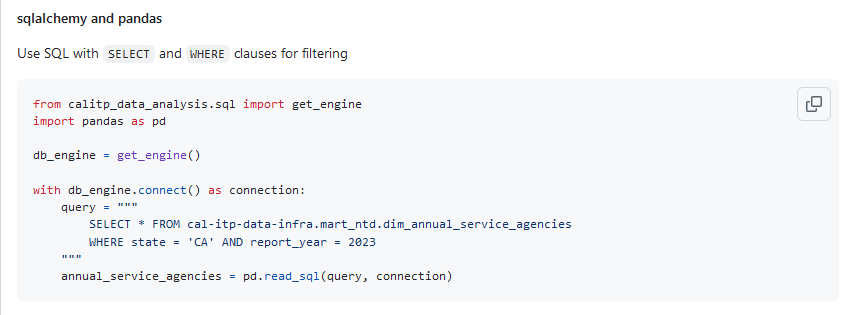

In [54]:
from calitp_data_analysis.tables import tbls
from calitp_data_analysis.sql import get_engine
from shared_utils import catalog_utils, rt_dates, schedule_rt_utils
from segment_speed_utils import helpers
import pandas as pd
db_engine = get_engine()

## Load NTD, compare with original function

In [41]:
def load_ntd() -> pd.DataFrame:
    with db_engine.connect() as connection:
        query = f"""
            SELECT
            number_of_state_counties,
            primary_uza_name,
            density,
            number_of_counties_with_service,
            state_admin_funds_expended,
            service_area_sq_miles,
            population,
            service_area_pop,
            subrecipient_type,
            primary_uza_code,
            reporter_type,
            organization_type,
            agency_name,
            voms_pt,
            voms_do,
            ntd_id,
            year
            FROM
            cal-itp-data-infra.mart_ntd.dim_annual_agency_information  
            WHERE state = 'CA' AND _is_current = TRUE
            """
        df = pd.read_sql(query,connection)
    df2 = df.sort_values(by=df.columns.tolist(), na_position="last")
    df3 = df2.groupby("agency_name").first().reset_index()
    return df3

In [40]:
def load_og_ntd(year: int) -> pd.DataFrame:
    """
    Load NTD Data stored in our warehouse.
    Select certain columns.
    """
    try:
        df = (
        tbls.mart_ntd.dim_annual_agency_information()
        >> filter(_.year == year, _.state == "CA", _._is_current == True)
        >> select(
            _.number_of_state_counties,
            _.primary_uza_name,
            _.density,
            _.number_of_counties_with_service,
            _.state_admin_funds_expended,
            _.service_area_sq_miles,
            _.population,
            _.service_area_pop,
            _.subrecipient_type,
            _.primary_uza_code,
            _.reporter_type,
            _.organization_type,
            _.agency_name,
            _.voms_pt,
            _.voms_do,
            _.ntd_id,
            _.year,
        )
        >> collect()
        )
    except:
        df = (
        tbls.mart_ntd.dim_annual_agency_information()
        >> filter(_.year == year, _.state == "CA", _._is_current == True)
        >> select(
            _.number_of_state_counties,
            _.uza_name,
            _.density,
            _.number_of_counties_with_service,
            _.state_admin_funds_expended,
            _.service_area_sq_miles,
            _.population,
            _.service_area_pop,
            _.subrecipient_type,
            _.reporter_type,
            _.organization_type,
            _.agency_name,
            _.voms_pt,
            _.voms_do,
            _.ntd_id,
            _.year,
            _.primary_uza,
        )
        >> collect()
        )
        df = df.rename(columns = {"uza_name":"primary_uza_name",
                                 "primary_uza":"primary_uza_code"})
    df2 = df.sort_values(by=df.columns.tolist(), na_position="last")
    df3 = df2.groupby("agency_name").first().reset_index()
    
    return df3

In [17]:
test_ntd = load_ntd()

In [24]:
og_ntd = load_og_ntd(2022)

In [25]:
og_ntd2 = load_og_ntd(2023)

In [27]:
og_ntd2.columns == test_ntd.columns

array([ True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True])

## Mobility

In [42]:
def load_mobility()->pd.DataFrame:
    with db_engine.connect() as connection:
        query = f"""
            SELECT
            agency_name,
            counties_served,
            hq_city,
            hq_county,
            is_public_entity,
            is_publicly_operating,
            funding_sources,
            on_demand_vehicles_at_max_service,
            vehicles_at_max_service
            FROM
            cal-itp-data-infra.mart_transit_database.dim_mobility_mart_providers  
            """
        df = pd.read_sql(query,connection)
    df2 = df.sort_values(
        by=["on_demand_vehicles_at_max_service","vehicles_at_max_service"], 
        ascending = [False, False]
    )
    df3 = df2.groupby('agency_name').first().reset_index()
    return df3

In [33]:
test_mobility = load_mobility()

In [21]:
test_mobility.sample()

,agency_name,ntd_id,hq_city,hq_county,counties_served,agency_website,caltrans_district_id,caltrans_district_name,is_public_entity,is_publicly_operating,funding_sources,on_demand_vehicles_at_max_service,vehicles_at_max_service,gtfs_schedule_uris
101,City of Santa Monica,90008,Santa Monica,Los Angeles,Los Angeles,http://www.bigbluebus.com/,7.0,Los Angeles / Ventura,True,True,5307;5309,124.0,143,https://gtfs.bigbluebus.com/current_swiftly.zi...


In [43]:
def load_og_mobility(
    cols: list = [
        "agency_name", "counties_served",
        "hq_city", "hq_county",
        "is_public_entity", "is_publicly_operating",
        "funding_sources",
        "on_demand_vehicles_at_max_service",
        "vehicles_at_max_service"
    ]
) -> pd.DataFrame:
    """
    Load mobility data (dim_mobility_mart_providers) 
    from our warehouse.
    """
    df = (
        tbls.mart_transit_database.dim_mobility_mart_providers()
        >> select(*cols)
        >> collect()
    )
    
    df2 = df.sort_values(
        by=["on_demand_vehicles_at_max_service","vehicles_at_max_service"], 
        ascending = [False, False]
    )
    
    df3 = df2.groupby('agency_name').first().reset_index()
    
    return df3

In [44]:
og_mobility = load_og_mobility()

In [35]:
og_mobility.columns == test_mobility.columns

array([ True,  True,  True,  True,  True,  True,  True,  True,  True])

In [45]:
def merge_ntd_mobility()->pd.DataFrame:
    """
    Merge NTD (dim_annual_ntd_agency_information) with 
    mobility providers (dim_mobility_mart_providers)
    and dedupe and keep 1 row per agency.
    """
    ntd = load_ntd()
    mobility = load_mobility()
    
    m1 = pd.merge(
        mobility,
        ntd,
        how="inner",
        on="agency_name"
    )

    m1 = m1.drop_duplicates(
        subset="agency_name"
    ).reset_index(
        drop=True
    ).drop(columns = "agency_name")
    
    # Wherever possible, allow nullable integers. These columns are integers, but can be
    # missing if we don't find corresponding NTD info
    integrify_cols = [
        "number_of_state_counties", "number_of_counties_with_service", 
        "service_area_sq_miles", "service_area_pop",
        "on_demand_vehicles_at_max_service", "vehicles_at_max_service",
        "voms_pt", "voms_do", "year",
    ]
    m1[integrify_cols] = m1[integrify_cols].astype("Int64")

    return m1

In [46]:
test_merge = merge_ntd_mobility()

In [47]:
test_merge.sample()

,counties_served,hq_city,hq_county,is_public_entity,is_publicly_operating,funding_sources,on_demand_vehicles_at_max_service,vehicles_at_max_service,number_of_state_counties,primary_uza_name,...,population,service_area_pop,subrecipient_type,primary_uza_code,reporter_type,organization_type,voms_pt,voms_do,ntd_id,year
203,None,Gerber,None,None,None,None,<NA>,14,<NA>,None,...,NaN,<NA>,Rural General Public Transit,NaN,Rural Reporter,"City, County or Local Government Unit or Depar...",14,<NA>,91089,2022


In [48]:
def create_gtfs_dataset_key_to_organization_crosswalk(
    analysis_date: str
) -> pd.DataFrame:
    """
    For every operator that appears in schedule data, 
    create a crosswalk that links to organization_source_record_id.
    For all our downstream outputs, at various aggregations,
    we need to attach these over and over again.
    """
    df = helpers.import_scheduled_trips(
        analysis_date,
        columns = ["gtfs_dataset_key", "name"],
        get_pandas = True
    ).rename(columns = {"schedule_gtfs_dataset_key": "gtfs_dataset_key"})
    # rename columns because we must use simply gtfs_dataset_key in schedule_rt_utils function
    
    # Get base64_url, organization_source_record_id and organization_name
    crosswalk = schedule_rt_utils.sample_gtfs_dataset_key_to_organization_crosswalk(
        df,
        analysis_date,
        quartet_data = "schedule",
        dim_gtfs_dataset_cols = ["key", "source_record_id", "base64_url"],
        dim_organization_cols = ["source_record_id", "name", "ntd_id_2022"],
        dim_county_geography_cols= ["caltrans_district"], # this is where caltrans_district appears by default
    )

    df_with_org = pd.merge(
        df.rename(columns = {"gtfs_dataset_key": "schedule_gtfs_dataset_key"}),
        crosswalk,
        on = "schedule_gtfs_dataset_key",
        how = "inner"
    )

    return df_with_org

In [50]:
rt_dates.y2025_dates

['2025-01-15',
 '2025-02-12',
 '2025-03-12',
 '2025-04-16',
 '2025-05-14',
 '2025-06-11',
 '2025-07-16']

In [64]:
[rt_dates.DATES['jun2025']]

['2025-06-11']

In [55]:
crosswalk_df = create_gtfs_dataset_key_to_organization_crosswalk(
            '2025-06-11',
        )

In [60]:
crosswalk_df = crosswalk_df.rename(columns = {"ntd_id_2022": "ntd_id"})

In [61]:
crosswalk_df = pd.merge(
            crosswalk_df,
            test_merge,
            on = ["ntd_id"],
            how = "left"
        )

# Drop ntd_id from ntd_df to avoid confusion
crosswalk_df = crosswalk_df.drop(columns = ["ntd_id"])

In [62]:
len(crosswalk_df)

212

In [63]:
len(crosswalk_df.drop_duplicates())

207